# 차량 공유 업체의 차량 파손 여부 분류하기

# 1. 환경 설정

#### (1) 라이브러리 불러오기

In [1]:
!pip install keras --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 22.3 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.2.1 which is incompatible.


In [2]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'

In [3]:
import gdown, zipfile
import os, glob, shutil
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt

import os
import random
from PIL import Image

from sklearn.model_selection import train_test_split

import keras

#### (2) 데이터 불러오기

1) 데이터 다운로드

2) 데이터 압축 해제

In [4]:
def dataset_extract(file_name):
    with zipfile.ZipFile(file_name, 'r') as zip_ref :
        file_list = zip_ref.namelist()

        if os.path.exists(f'/content/{file_name[-14:-4]}/') :
            print(f'데이터셋 폴더가 이미 존재합니다.')
            return

        else :
            for f in tqdm(file_list, desc='Extracting', unit='files'):
                zip_ref.extract(member=f, path=f'/content/{file_name[-14:-4]}/')

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
dataset_extract('/content/drive/MyDrive/Colab Notebooks/KT_MP_4_1/Car_Images.zip')

Extracting: 100%|██████████| 607/607 [00:20<00:00, 29.00files/s]


3) 데이터 조회

In [27]:
# 폴더별 이미지 데이터 갯수 확인

# 데이터셋 디렉토리 경로 설정
dataset_directory = '/content/Car_Images/'

# 서브디렉토리 리스트 얻기
subdirectories = [d for d in os.listdir(dataset_directory) if os.path.isdir(os.path.join(dataset_directory, d))]

# 각 서브디렉토리 내의 파일 개수 계산 및 출력
for subdir in tqdm(subdirectories, desc='Counting files in subdirectories'):
    # 서브디렉토리의 전체 경로
    subdir_path = os.path.join(dataset_directory, subdir)

    # 서브디렉토리 내의 파일 리스트 얻기
    files = [f for f in os.listdir(subdir_path) if os.path.isfile(os.path.join(subdir_path, f))]

    # 파일 개수 출력
    print(f'{subdir}: {len(files)} files')

Counting files in subdirectories: 100%|██████████| 2/2 [00:00<00:00, 184.78it/s]

normal: 302 files
abnormal: 303 files


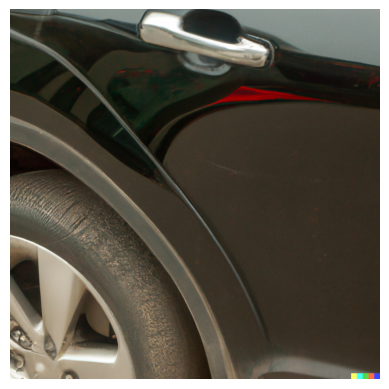

Random image size: (1024, 1024)


In [28]:
# 정상 차량 랜덤 이미지 확인 및 형태 확인

path_normal = '/content/Car_Images/normal'

# 해당 경로의 파일 목록 가져오기
files = os.listdir(path_normal)

# 랜덤 파일 선택
random_file = random.choice(files)

# 이미지 경로
img_path = os.path.join(path_normal, random_file)

# 이미지 열기
img = Image.open(img_path)

# 이미지 보여주기
plt.imshow(img)
plt.axis('off') # 축 끄기
plt.show()

# 이미지 크기 출력
print(f'Random image size: {img.size}')

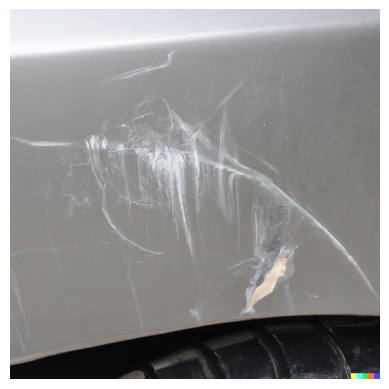

Random image size: (1024, 1024)


In [29]:
# 파손 차량 랜덤 이미지 확인 및 형태 확인

path_abnormal = '/content/Car_Images/abnormal'

# 해당 경로의 파일 목록 가져오기
files = os.listdir(path_abnormal)

# 랜덤 파일 선택
random_file = random.choice(files)

# 이미지 경로
img_path = os.path.join(path_abnormal, random_file)

# 이미지 열기
img = Image.open(img_path)

# 이미지 보여주기
plt.imshow(img)
plt.axis('off') # 축 끄기
plt.show()

# 이미지 크기 출력
print(f'Random image size: {img.size}')

# 2. 데이터 전처리

(1) Y: 클래스 만들기

normal: 0

abnormal: 1

In [30]:
# normal 이미지의 수 확인
num_normal = len([name for name in os.listdir(path_normal) if os.path.isfile(os.path.join(path_normal, name))])

# abnormal 이미지의 수 확인
num_abnormal = len([name for name in os.listdir(path_abnormal) if os.path.isfile(os.path.join(path_abnormal, name))])

# Y 배열 생성: normal은 0, abnormal은 1
Y = np.array([0]*num_normal + [1]*num_abnormal)

print(Y.shape)

(605,)


(2) X: 데이터 리스트 통합

In [31]:
X = glob.glob("/content/Car_Images/normal/*") + glob.glob("/content/Car_Images/abnormal/*")

print(X[:3])
print(X[-3:])

['/content/Car_Images/normal/DALLíñE 2023-03-11 14.13.06 - part of a car.png', '/content/Car_Images/normal/DALLíñE 2023-03-11 01.06.32 - photo of a part of car.png', '/content/Car_Images/normal/DALLíñE 2023-03-10 23.39.17 - photo of a part of car without blemish.png']
['/content/Car_Images/abnormal/DALLíñE 2023-03-11 14.49.32 - dents of a car.png', '/content/Car_Images/abnormal/DALLíñE 2023-03-11 17.15.51 - damaged car.png', '/content/Car_Images/abnormal/DALLíñE 2023-03-10 23.37.30 - photo of a part of car without blemish.png']


(3) 데이터셋 분리

1) train set, test set = 90%, 10%

2) train set, valid set = 90% 10%

In [32]:
# 1) train set, test set = 90%, 10%
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=42)

# 2) train set, valid set = 90%, 10%
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.1, random_state=42)

# 결과 출력
print(f'훈련 데이터셋 크기: {len(x_train)}, {y_train.shape}')
print(f'검증 데이터셋 크기: {len(x_valid)}, {y_valid.shape}')
print(f'테스트 데이터셋 크기: {len(x_test)}, {y_test.shape}')

훈련 데이터셋 크기: 489, (489,)
검증 데이터셋 크기: 55, (55,)
테스트 데이터셋 크기: 61, (61,)


(4) X: image to array

1) 이미지 np.array 형태로 변환

2) 이미지 사이즈 줄이기

3) 스케일링

In [33]:
def x_preprocessing(img_list) :
    bin_list = []

    for img in tqdm(img_list) :
        img = keras.utils.load_img(img, target_size=(128, 128))   # image resize
        img = keras.utils.img_to_array(img)
        img /= 255.0   # scaling
        bin_list.append(img)

    return np.array(bin_list)

In [34]:
x_train = x_preprocessing(x_train)
x_valid = x_preprocessing(x_valid)
x_test = x_preprocessing(x_test)

100%|██████████| 61/61 [00:02<00:00, 29.70it/s]


In [35]:
# 변환 후의 크기 확인
print(f'훈련 데이터셋 크기: {x_train.shape}')
print(f'검증 데이터셋 크기: {x_valid.shape}')
print(f'테스트 데이터셋 크기: {x_test.shape}')

훈련 데이터셋 크기: (489, 128, 128, 3)
검증 데이터셋 크기: (55, 128, 128, 3)
테스트 데이터셋 크기: (61, 128, 128, 3)


# CNN 모델링

In [16]:
import keras

from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dropout, Input, MaxPool2D
from keras.backend import clear_session
from keras.callbacks import EarlyStopping

from sklearn.metrics import classification_report, confusion_matrix

In [19]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.figure(figsize=(10,6))
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylim([0, 3])

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

In [ ]:
# input_shape : feature 수 도출
nfeatures = x_train.shape[1:]
nfeatures

(128, 128, 3)

# 1. Model1

1) 구조 설계

In [ ]:
# 메모리 정리
clear_session()

# 모델 구조 설계
model1 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=nfeatures),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

# 모델 컴파일
model1.compile(optimizer='adam',
               loss='binary_crossentropy',
               metrics=['accuracy'])

# 모델 요약
model1.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       1,605,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,699,009 (6.48 MB)

 Trainable params: 1,699,009 (6.48 MB)

 Non-trainable params: 0 (0.00 B)

2) 학습

Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 275ms/step - accuracy: 0.5258 - loss: 0.9435 - val_accuracy: 0.7818 - val_loss: 0.6258
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7606 - loss: 0.6060 - val_accuracy: 0.7273 - val_loss: 0.6058
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7032 - loss: 0.6088 - val_accuracy: 0.8545 - val_loss: 0.5029
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8262 - loss: 0.5017 - val_accuracy: 0.8727 - val_loss: 0.3895
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8333 - loss: 0.4325 - val_accuracy: 0.8364 - val_loss: 0.4948
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7989 - loss: 0.4313 - val_accuracy: 0.8545 - val_loss: 0.3554
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8787 - loss: 0.3077 - val_accuracy: 0.8364 - val_loss: 0.5140
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8627 - loss: 0.3578 - val_accuracy: 

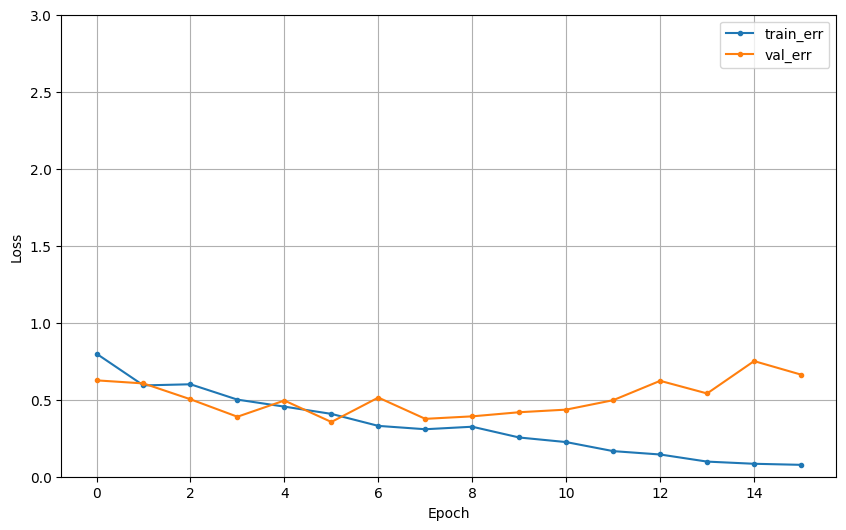

In [ ]:
# EarlyStopping 설정
min_de = 0
pat = 10

es = EarlyStopping(monitor = 'val_loss', min_delta = min_de, patience = pat)


# 학습
hist = model1.fit(x_train, y_train, epochs = 100, validation_data=(x_valid, y_valid),
                  callbacks = [es]).history
dl_history_plot(hist)

3) 성능 평가

In [ ]:
# 테스트 데이터셋에 대한 예측 수행
predictions = model1.predict(x_test)
predictions = np.round(predictions).astype(int)  # 확률을 이진 값으로 변환

print('Model1')

# Confusion Matrix 출력
print("Confusion Matrix:")
print(confusion_matrix(y_test, predictions))

# Classification Report 출력
print("\nClassification Report:")
print(classification_report(y_test, predictions))

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 924ms/step
Model1
Confusion Matrix:
[[26  6]
 [ 6 23]]

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.81      0.81        32
           1       0.79      0.79      0.79        29

    accuracy                           0.80        61
   macro avg       0.80      0.80      0.80        61
weighted avg       0.80      0.80      0.80        61



# 2. Model2

1) 구조 설계

In [ ]:
# 메모리 정리
clear_session()

# 모델 구조 설계
model2 = Sequential([

    Conv2D(32, (3, 3), strides=(1, 1), padding='same', activation='relu', input_shape=nfeatures),
    Conv2D(32, (3, 3), strides=(1, 1), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), strides=(1, 1), padding='same', activation='relu'),
    Conv2D(64, (3, 3), strides=(1, 1), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(1024, activation='relu'),
    BatchNormalization(),
    Dropout(0.35),

    Dense(1, activation='sigmoid')
])

# 모델 컴파일
model2.compile(optimizer='adam',
               loss='binary_crossentropy',
               metrics=['accuracy'])

# 모델 요약
model2.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 128, 128, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128, 128, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 64, 64, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 65536)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │      67,109,888 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │           1,025 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 67,180,961 (256.28 MB)

 Trainable params: 67,178,721 (256.27 MB)

 Non-trainable params: 2,240 (8.75 KB)

2) 학습

Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.7512 - loss: 1.4971 - val_accuracy: 0.6364 - val_loss: 0.7185
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.8477 - loss: 0.4760 - val_accuracy: 0.6182 - val_loss: 1.2045
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.9193 - loss: 0.2392 - val_accuracy: 0.6182 - val_loss: 4.4263
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.9404 - loss: 0.1813 - val_accuracy: 0.6182 - val_loss: 4.7719
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.9581 - loss: 0.1299 - val_accuracy: 0.6182 - val_loss: 8.4130
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.9682 - loss: 0.0924 - val_accuracy: 0.6182 - val_loss: 10.3466
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.9904 - loss: 0.0489 - val_accuracy: 0.6182 - val_loss: 11.2394
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.9943 - loss: 0.0371 - val_accuracy: 0

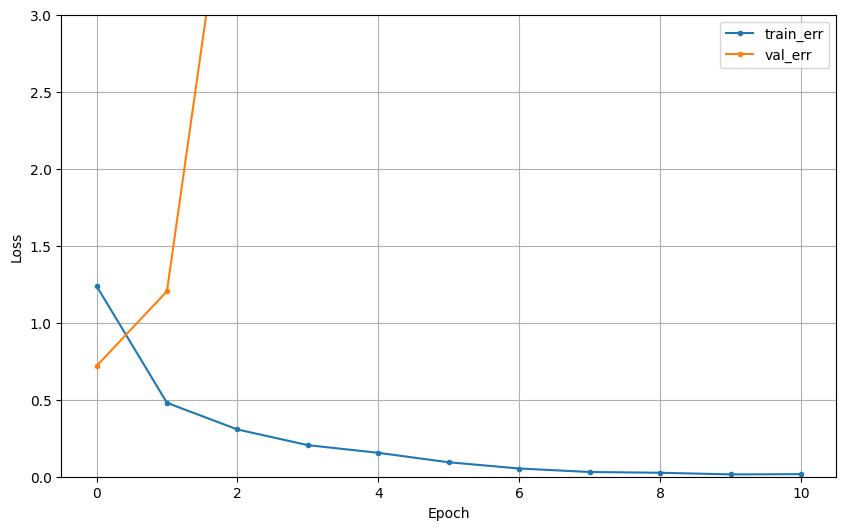

In [ ]:
# EarlyStopping 설정
min_de = 0
pat = 10

es = EarlyStopping(monitor = 'val_loss', min_delta = min_de, patience = pat)


# 학습
hist = model2.fit(x_train, y_train, epochs = 100, validation_data=(x_valid, y_valid),
                  callbacks = [es]).history
dl_history_plot(hist)

3) 성능 평가

In [ ]:
# 테스트 데이터셋에 대한 예측 수행
predictions = model2.predict(x_test)
predictions = np.round(predictions).astype(int)  # 확률을 이진 값으로 변환

print('Model2')

# Confusion Matrix 출력
print("Confusion Matrix:")
print(confusion_matrix(y_test, predictions))

# Classification Report 출력
print("\nClassification Report:")
print(classification_report(y_test, predictions))

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step
Model2
Confusion Matrix:
[[ 0 32]
 [ 0 29]]

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        32
           1       0.48      1.00      0.64        29

    accuracy                           0.48        61
   macro avg       0.24      0.50      0.32        61
weighted avg       0.23      0.48      0.31        61



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# 3. Model3

1) 구조 설계

In [ ]:
# 메모리 정리
clear_session()

# 모델 구조 설계
model3 = Sequential([

    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=nfeatures),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')])

# 모델 컴파일
model3.compile(optimizer='adam',
               loss='binary_crossentropy',
               metrics=['accuracy'])

# 모델 요약 출력
model3.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 124, 124, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       1,605,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,735,937 (6.62 MB)

 Trainable params: 1,735,937 (6.62 MB)

 Non-trainable params: 0 (0.00 B)

2) 학습

Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 29s 759ms/step - accuracy: 0.5081 - loss: 0.8387 - val_accuracy: 0.5273 - val_loss: 0.6881
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 17s 39ms/step - accuracy: 0.5891 - loss: 0.6705 - val_accuracy: 0.8364 - val_loss: 0.6189
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.6730 - loss: 0.6202 - val_accuracy: 0.6727 - val_loss: 0.6010
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.7808 - loss: 0.5114 - val_accuracy: 0.8000 - val_loss: 0.4397
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.7780 - loss: 0.4889 - val_accuracy: 0.8364 - val_loss: 0.4090
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.7703 - loss: 0.5004 - val_accuracy: 0.8545 - val_loss: 0.3497
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.8128 - loss: 0.4159 - val_accuracy: 0.8364 - val_loss: 0.3430
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.8011 - loss: 0.4239 - val_accuracy:

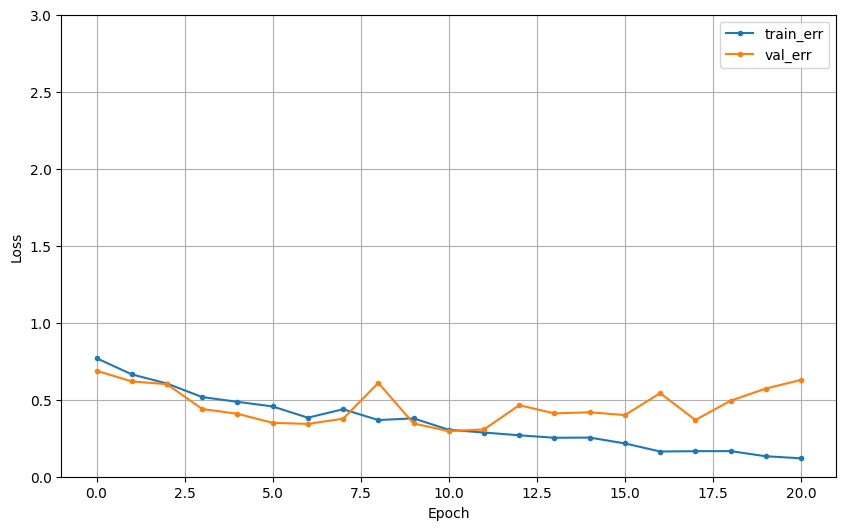

In [ ]:
# EarlyStopping 설정
min_de = 0
pat = 10

es = EarlyStopping(monitor = 'val_loss', min_delta = min_de, patience = pat)


# 학습
hist = model3.fit(x_train, y_train, epochs = 100, validation_data=(x_valid, y_valid),
                  callbacks = [es]).history
dl_history_plot(hist)

3) 성능 평가

In [ ]:
# 테스트 데이터셋에 대한 예측 수행
predictions = model3.predict(x_test)
predictions = np.round(predictions).astype(int)  # 확률을 이진 값으로 변환

print('Model3')

# Confusion Matrix 출력
print("Confusion Matrix:")
print(confusion_matrix(y_test, predictions))

# Classification Report 출력
print("\nClassification Report:")
print(classification_report(y_test, predictions))

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step
Model3
Confusion Matrix:
[[25  7]
 [ 9 20]]

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.78      0.76        32
           1       0.74      0.69      0.71        29

    accuracy                           0.74        61
   macro avg       0.74      0.74      0.74        61
weighted avg       0.74      0.74      0.74        61



# 4. Model4

1) 구조 설계

In [ ]:
# 메모리 정리
clear_session()

# 모델 구조 설계
model4 = Sequential([
    Conv2D(256, kernel_size=(5, 5), activation='relu', padding='same', input_shape=nfeatures),
    Conv2D(256, (5, 5), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# 모델 컴파일
model4.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# 모델 요약 출력
model4.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 256)       │          19,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 128, 128, 256)       │       1,638,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 64, 64, 128)         │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 131072)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       8,388,672 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,489,473 (40.01 MB)

 Trainable params: 10,489,473 (40.01 MB)

 Non-trainable params: 0 (0.00 B)

2) 학습

Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 200s 5s/step - accuracy: 0.4775 - loss: 3.5304 - val_accuracy: 0.6182 - val_loss: 0.6890
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 645ms/step - accuracy: 0.5576 - loss: 0.6925 - val_accuracy: 0.6182 - val_loss: 0.6896
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 632ms/step - accuracy: 0.5251 - loss: 0.6919 - val_accuracy: 0.6545 - val_loss: 0.6798
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 643ms/step - accuracy: 0.5291 - loss: 0.6918 - val_accuracy: 0.6545 - val_loss: 0.6926
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 625ms/step - accuracy: 0.5850 - loss: 0.6890 - val_accuracy: 0.6545 - val_loss: 0.6700
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 641ms/step - accuracy: 0.5333 - loss: 0.6782 - val_accuracy: 0.6545 - val_loss: 0.6862
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 632ms/step - accuracy: 0.5992 - loss: 0.6620 - val_accuracy: 0.7091 - val_loss: 0.6449
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 643ms/step - accuracy: 0.5628 - loss: 0.6590 - va

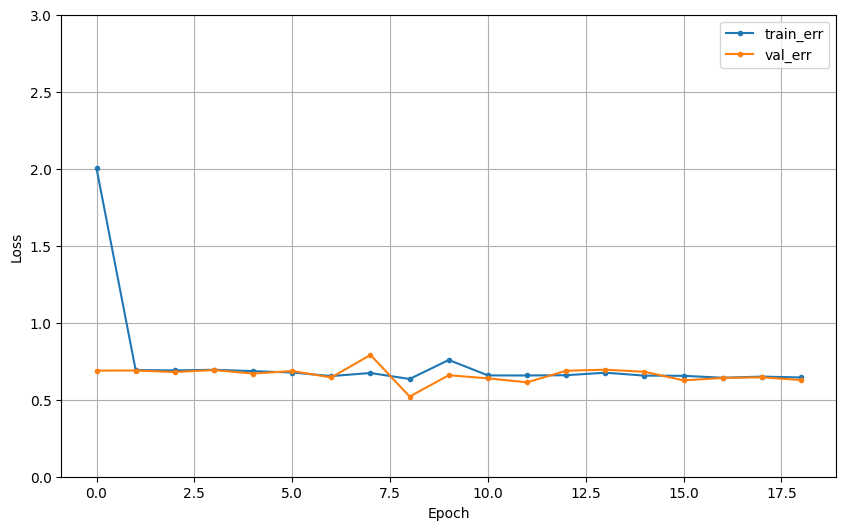

In [ ]:
# EarlyStopping 설정
min_de = 0
pat = 10

es = EarlyStopping(monitor = 'val_loss', min_delta = min_de, patience = pat)


# 학습
hist = model4.fit(x_train, y_train, epochs = 100, validation_data=(x_valid, y_valid),
                  callbacks = [es]).history
dl_history_plot(hist)

3) 성능 평가

In [ ]:
# 테스트 데이터셋에 대한 예측 수행
predictions = model4.predict(x_test)
predictions = np.round(predictions).astype(int)  # 확률을 이진 값으로 변환

print('Model4')

# Confusion Matrix 출력
print("Confusion Matrix:")
print(confusion_matrix(y_test, predictions))

# Classification Report 출력
print("\nClassification Report:")
print(classification_report(y_test, predictions))

2/2 ━━━━━━━━━━━━━━━━━━━━ 39s 38s/step
Model4
Confusion Matrix:
[[21 11]
 [10 19]]

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.66      0.67        32
           1       0.63      0.66      0.64        29

    accuracy                           0.66        61
   macro avg       0.66      0.66      0.66        61
weighted avg       0.66      0.66      0.66        61



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random as rd

# labels 딕셔너리
labels = {0: 'normal', 1: 'abnormal'}

# 모델의 예측 결과 확인 해 보기
def check_pred(model, labels, x_test, y_test):

    predictions = model.predict(x_test)

    id = rd.randrange(0, len(x_test))

    print(f'id = {id}')
    print(f'다음 그림은 {labels[y_test[id]]} 입니다.')

    prob_abnormal = np.floor(predictions[id][0]*100).tolist()
    prob_normal = np.floor((1 - predictions[id][0])*100).tolist()

    prob_dict = {
        labels[0]: prob_normal,
        labels[1]: prob_abnormal
    }

    print('모델의 카테고리별 확률 : ')
    print(prob_dict)
    print()

    # 정답 여부 확인
    single_pred_test = (predictions > 0.5).astype(int).flatten()
    if y_test[id] == single_pred_test[id]:
        print('정답입니다')
    else:
        print('틀렸어요')

    plt.imshow(x_test[id])
    plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
id = 31
다음 그림은 abnormal 입니다.
모델의 카테고리별 확률 : 
{'normal': 66.0, 'abnormal': 33.0}

틀렸어요


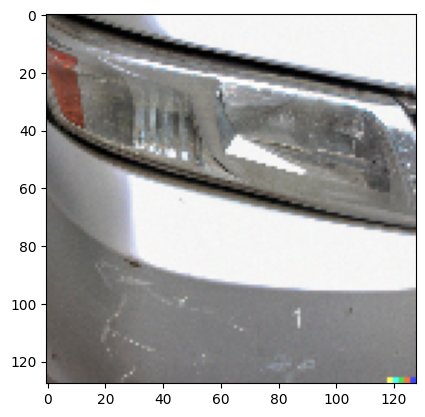

In [ ]:
check_pred(model3, labels, x_test, y_test)

# Transfer Learning

## Image_dataset_from_directory

In [55]:
import tensorflow as tf
from keras.preprocessing import image_dataset_from_directory

In [56]:
# 데이터셋 경로 설정
dataset_dir = "/content/Car_Images/"

In [57]:
# 훈련 및 검증 데이터셋 생성 전에 정규화 하는 Rescaling 레이어 추가
preprocessing_model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255)
])

In [58]:
# 훈련 데이터셋 생성
train_dataset = image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(128, 128),
    batch_size=32,
    class_names=['normal', 'abnormal']
    ).map(lambda x, y: (preprocessing_model(x), y))

# 검증 데이터셋 생성
valid_dataset = image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(128, 128),
    batch_size=32,
    class_names=['normal', 'abnormal']
    ).map(lambda x, y: (preprocessing_model(x), y))

Found 605 files belonging to 2 classes.
Using 484 files for training.
Found 605 files belonging to 2 classes.
Using 121 files for validation.


In [59]:
# 데이터셋 구성 확인
for image_batch, labels_batch in train_dataset:
    print(image_batch.shape)
    print(labels_batch.shape)
    break  # 하나의 배치만 확인

(32, 128, 128, 3)
(32,)


In [60]:
# input_shape : feature 수 도출
nfeatures = image_batch.shape[1:]
nfeatures

TensorShape([128, 128, 3])

## Transfer Learning

1) Inception V3 모델 불러와서 저장하기

• include_top = False로 설정하여 분류기를 제외하고 미리 학습된 가중치 imagent를 로드

• .trainable = False로 설정하여 불러온 모델의 모든 레이어들을 Frozen 시켜 가중치를 고정

In [61]:
from keras.applications import InceptionV3
from keras.layers import GlobalAveragePooling2D, Dense
from keras.models import Model
from keras import Sequential
from keras.layers import Input, Flatten, Dense
from keras.layers import RandomFlip, RandomRotation

In [62]:
# InceptionV3 모델 불러오기
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=nfeatures)
base_model.trainable = False  # 모델의 모든 레이어를 Frozen 시킴

# 불러온 모델 확인
base_model.summary()

Model: "inception_v3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12            │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_282 (Conv2D)       │ (None, 63, 63, 32)     │            864 │ input_layer_12[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_282   │ (None, 63, 63, 32)     │             96 │ conv2d_282[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_282            │ (None, 63, 63, 32)     │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_283 (Conv2D)       │ (None, 61, 61, 32)     │          9,216 │ activation_282[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_283   │ (None, 61, 61, 32)     │             96 │ conv2d_283[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_283            │ (None, 61, 61, 32)     │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_284 (Conv2D)       │ (None, 61, 61, 64)     │         18,432 │ activation_283[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_284   │ (None, 61, 61, 64)     │            192 │ conv2d_284[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_284            │ (None, 61, 61, 64)     │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_12          │ (None, 30, 30, 64)     │              0 │ activation_284[0][0]   │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_285 (Conv2D)       │ (None, 30, 30, 80)     │          5,120 │ max_pooling2d_12[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_285   │ (None, 30, 30, 80)     │            240 │ conv2d_285[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_285            │ (None, 30, 30, 80)     │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_286 (Conv2D)  

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 21,802,784 (83.17 MB)

2) Inception V3 모델과 연결하여 구조 설계

• Inception V3를 불러온 후 다른 레이어와 연결

• Image Augmentation Layer를 만들어 데이터 증강

In [63]:
# 데이터 증강 레이어
data_augmentation = Sequential([
    RandomFlip('horizontal'),
    RandomRotation(0.2),
])

# 새 모델 구조 설계
inputs = Input(shape=nfeatures)
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs, outputs)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 모델 구조 확인
model.summary()

Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)          │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_6 (Sequential)            │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ inception_v3 (Functional)            │ (None, 2, 2, 2048)          │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_3           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │           1,025 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,901,985 (91.18 MB)

 Trainable params: 2,099,201 (8.01 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

3) 학습

In [64]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.figure(figsize=(10,6))
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylim([0, 3])

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 30s 849ms/step - accuracy: 0.5725 - loss: 5.6502 - val_accuracy: 0.8760 - val_loss: 0.3237
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 18s 689ms/step - accuracy: 0.8839 - loss: 0.2749 - val_accuracy: 0.8760 - val_loss: 0.2748
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 15s 496ms/step - accuracy: 0.9167 - loss: 0.2331 - val_accuracy: 0.9008 - val_loss: 0.2805
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 22s 720ms/step - accuracy: 0.8898 - loss: 0.2929 - val_accuracy: 0.8843 - val_loss: 0.2806
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 549ms/step - accuracy: 0.8800 - loss: 0.2617 - val_accuracy: 0.8843 - val_loss: 0.2745
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 511ms/step - accuracy: 0.9198 - loss: 0.2260 - val_accuracy: 0.8926 - val_loss: 0.2821
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 21s 499ms/step - accuracy: 0.9236 - loss: 0.1972 - val_accuracy: 0.8678 - val_loss: 0.3826
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 21s 567ms/step - accuracy: 0.8967 - loss: 0.2685 - 

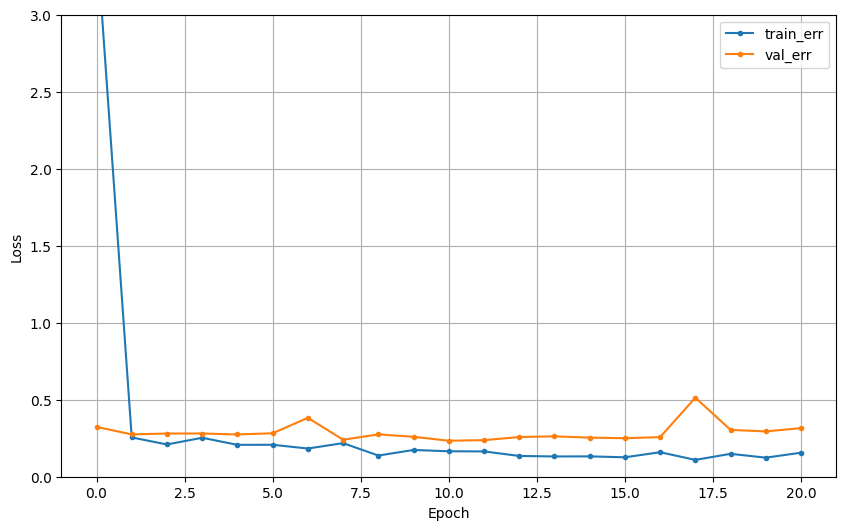

In [65]:
# EarlyStopping 설정
min_de = 0
pat = 10

es = EarlyStopping(monitor = 'val_loss', min_delta = min_de, patience = pat)

# 학습
hist = model.fit(train_dataset, epochs=100, validation_data=valid_dataset,
                 callbacks=[es]).history
dl_history_plot(hist)

4) 성능 평가

In [66]:
# 테스트 데이터셋 준비가 필요
# 예측
predictions = model.predict(x_test)
predictions = np.round(predictions).astype(int)


# 평가
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step
[[31  1]
 [ 1 28]]
              precision    recall  f1-score   support

           0       0.97      0.97      0.97        32
           1       0.97      0.97      0.97        29

    accuracy                           0.97        61
   macro avg       0.97      0.97      0.97        61
weighted avg       0.97      0.97      0.97        61



In [67]:
import numpy as np
import matplotlib.pyplot as plt
import random as rd

# labels 딕셔너리
labels = {0: 'normal', 1: 'abnormal'}

# 모델의 예측 결과 확인 해 보기
def check_pred(model, labels, x_test, y_test):

    predictions = model.predict(x_test)

    id = rd.randrange(0, len(x_test))

    print(f'id = {id}')
    print(f'다음 그림은 {labels[y_test[id]]} 입니다.')

    prob_abnormal = np.floor(predictions[id][0]*100).tolist()
    prob_normal = np.floor((1 - predictions[id][0])*100).tolist()

    prob_dict = {
        labels[0]: prob_normal,
        labels[1]: prob_abnormal
    }

    print('모델의 카테고리별 확률 : ')
    print(prob_dict)
    print()

    # 정답 여부 확인
    single_pred_test = (predictions > 0.5).astype(int).flatten()
    if y_test[id] == single_pred_test[id]:
        print('정답입니다')
    else:
        print('틀렸어요')

    plt.imshow(x_test[id])
    plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
id = 28
다음 그림은 abnormal 입니다.
모델의 카테고리별 확률 : 
{'normal': 6.0, 'abnormal': 93.0}

정답입니다


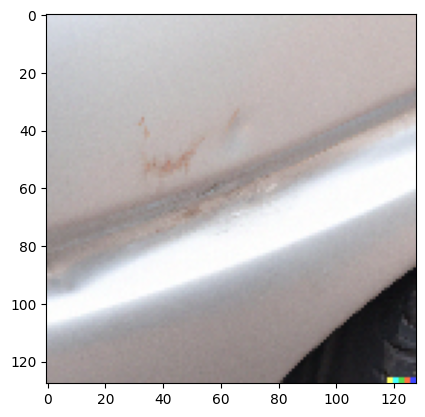

In [109]:
check_pred(model, labels, x_test, y_test)

In [77]:
import numpy as np
import matplotlib.pyplot as plt
import random as rd

# labels 딕셔너리
labels = {0: 'normal', 1: 'abnormal'}

# 모델의 예측 결과 중 틀린 것만 확인 해 보기
def check_incorrect_predictions(model, labels, x_test, y_test):
    predictions = model.predict(x_test)
    # 예측된 결과를 이진값으로 변환
    predicted_classes = (predictions > 0.5).astype(int).flatten()

    # 실제값과 예측값이 일치하지 않는 인덱스를 찾음
    incorrect_indices = [i for i, (actual, pred) in enumerate(zip(y_test, predicted_classes)) if actual != pred]

    if len(incorrect_indices) == 0:
        print("모든 예측이 정확합니다!")
    else:
        # 틀린 예측 중에서 무작위로 하나를 선택
        id = rd.choice(incorrect_indices)
        print(f'id = {id}')
        print(f'다음 그림은 {labels[y_test[id]]} 입니다.')

        prob_abnormal = np.floor(predictions[id][0] * 100).tolist()
        prob_normal = np.floor((1 - predictions[id][0]) * 100).tolist()

        prob_dict = {
            labels[0]: prob_normal,
            labels[1]: prob_abnormal
        }

        print('모델의 카테고리별 확률 : ')
        print(prob_dict)
        print()

        print('틀렸어요')
        plt.imshow(x_test[id])
        plt.show()

# 예를 들어 모델, x_test, y_test 데이터를 사용하여 함수 호출
# check_incorrect_predictions(model, labels, x_test, y_test)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
id = 45
다음 그림은 normal 입니다.
모델의 카테고리별 확률 : 
{'normal': 20.0, 'abnormal': 79.0}

틀렸어요


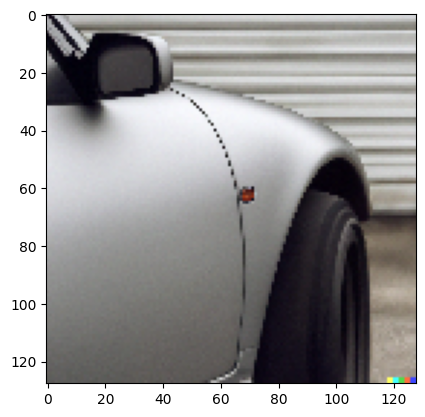

In [90]:
check_incorrect_predictions(model, labels, x_test, y_test)